# Flow Calculation
In this notebook, we present the approach we used to estimate the incoming and outgoing water flow rates of the two tanks in our system.

## Detection of the water volume in an image
To be able to detect the volume of water present inside the tanks of the system at any given time, the function mapping the water level in a tank to the volume it contains needs to be learned. This is done as follows.

First, pictures of the system with volumes of water varying from 0.0 to 1.4 litres in steps of 0.1L are taken. For each volume, 3 different images are captured. Below, samples of the photos taken during this phase are shown.

Populating the interactive namespace from numpy and matplotlib


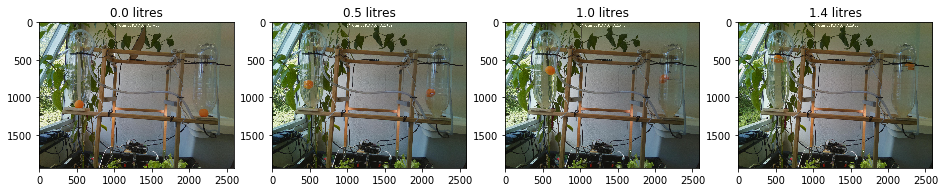

In [8]:
import os
import imageio
import matplotlib.pyplot as plt

# The images are loaded.
imgs = []
for img in os.listdir('files/volumes'):
    if img.endswith('.jpg'):
        imgs.append((float('.'.join(img.split('.')[0:2])),
                     imageio.imread(os.path.join('files/volumes', img))))

names, images = zip(*sorted(imgs))

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 5)

# They are plotted in ascending order of volume.
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(images[i])
    ax.set_title(str(names[i])+' litres')

The water level in the photos is then detected with the help of the image recognition algorithm presented in the *ImageRecognition* notebook. The example for the right tank is illustrated below.

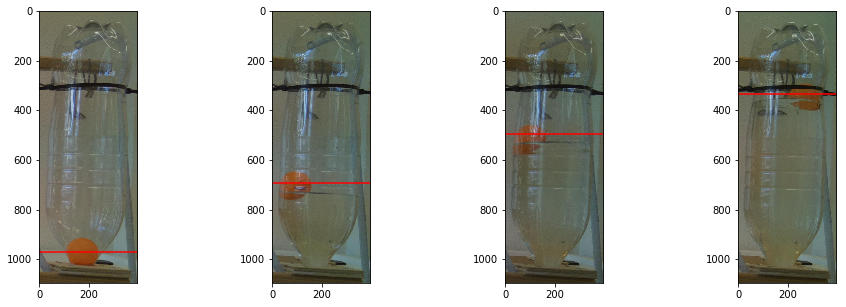

In [9]:
from utils import crop_image, detect_ball, show_height

# The cropping coordinates for the right tank are defined.
right_crop = dict(topleft=(240, 2015), bottomright=(1335, 2410))

fig = plt.figure()
for i, image in enumerate(images):
    # Each image is cropped.
    cropped_image = crop_image(image, right_crop['topleft'], right_crop['bottomright'])
    # The ball is detected.
    (_, ball_y) = detect_ball(cropped_image, 80)
    # The height of the ball is plotted.
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(cropped_image)
    ax.axhline(y=ball_y, color='r')

The average water level between the three images captured for each volume is computed. Since the amount of water is known in every image, a trace of the volume given the average water level (or ball height) can be produced. A polynomial regression is applied on this trace to approximate the function that maps the water level to the volume.

Text(0.5,1,"Water volume in the right tank given the ball's height")

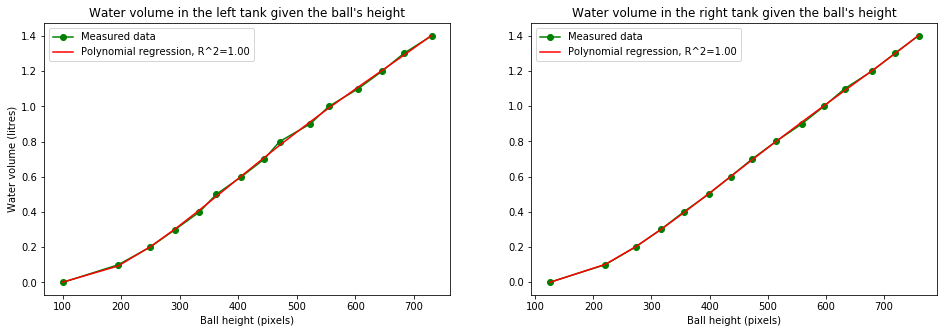

In [10]:
from utils import load_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

    
# The traces of the water volume given the ball height for the left and right tank
# are loaded.
x_left, y_left = load_data('files/height_volume_left.csv')
x_right, y_right = load_data('files/height_volume_right.csv')

# Polynomial regressions are fit on the traces.
x_powers_left = np.c_[x_left, np.square(x_left), np.power(x_left, 3), np.power(x_left, 4)]
x_powers_right = np.c_[x_right, np.square(x_right), np.power(x_right, 3), np.power(x_right, 4)]

reg_left = LinearRegression()
reg_left.fit(x_powers_left, y_left)
y_pred_left = reg_left.predict(x_powers_left)
r2_left = r2_score(y_left, y_pred_left)

reg_right = LinearRegression()
reg_right.fit(x_powers_right, y_right)
y_pred_right = reg_right.predict(x_powers_right)
r2_right = r2_score(y_right, y_pred_right)

# Plot of the results.
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x_left, y_left, '-og')
ax1.plot(x_left, y_pred_left, '-r')
ax1.legend(["Measured data",
            "Polynomial regression, R^2={:.2f}".format(r2_left)])
ax1.set_title("Water volume in the left tank given the ball's height")
plt.xlabel('Ball height (pixels)')
plt.ylabel('Water volume (litres)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(x_right, y_right, '-og')
ax2.plot(x_right, y_pred_right, '-r')
ax2.legend(["Measured data",
            "Polynomial regression, R^2={:.2f}".format(r2_right)])
plt.xlabel('Ball height (pixels)')
ax2.set_title("Water volume in the right tank given the ball's height")

When a photo of the system is taken, the volume present in its tanks can be estimated by detecting the balls' heights and using the regressions. This way, we are able to automatically detect unknown water volumes in the system. An example is presented below.

In [11]:
from utils import get_ball_height

# An image with unknown water volumes in the tanks is loaded.
image = imageio.imread('files/system_image.jpg')

# The ball's height in the right tank is detected.
ball_height = get_ball_height(image, 80, right_crop['topleft'], right_crop['bottomright'])

# The regression for the right tank is used to determine the amount of water present in the image.
height_powers = np.c_[ball_height, np.square(ball_height), np.power(ball_height, 3), np.power(ball_height, 4)]
volume = reg_right.predict(height_powers)
print("Volume of water in the right tank: {:.2f} litres".format(volume[0][0]))

Volume of water in the right tank: 0.91 litres


## Learning the water flow rates

### Volume/time traces
To be able to compute the volumetric flow rates of the two tanks in the system, the function describing the evolution of the water volume in the tanks over time needs to be learned. This is done by taking pictures of the system at regular intervals (e.g. every two seconds) while the tanks are filled by the pumps and emptied on the plants. The volume of water in each image is then detected with the method described above. Since the time at which each image was captured is known, a trace of the volume over time can be produced for each water tank.

Text(0.5,0,'time (seconds)')

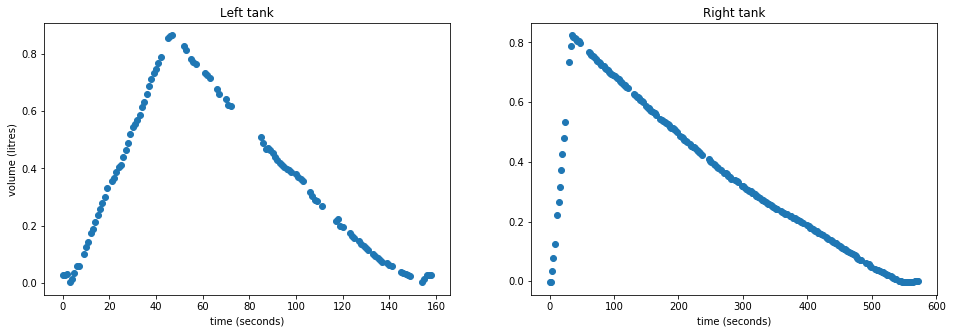

In [14]:
# The traces of the water volume over time for the left and right tank
# are loaded.
xflow_left, yflow_left = load_data('files/time_volume_left.csv')
xflow_right, yflow_right = load_data('files/time_volume_right.csv')

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(xflow_left, yflow_left, 'o')
ax1.set_title("Left tank")
plt.xlabel('time (seconds)')
plt.ylabel('volume (litres)')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(xflow_right, yflow_right, 'o')
ax2.set_title("Right tank")
plt.xlabel('time (seconds)')

### Regression on the traces
The functions describing the evolution of the water volume over time when the tanks are filled and emptied are approximated with regressions applied on the volume/time traces.

First, the traces are split in two separate sets of points: one for the filling phase (which will allow us to estimate the incoming flow rate), and one for the emptying phase (for the outgoing flow rate). Splitting is performed at the point where the volume is maximum in each tank, since this point is reached when the pumps are stopped and the filling phase is interrupted.

In [17]:
# The point where the volume is maximum gives us the time at which
# the pump stopped sending water to the tank.
splitting_left = np.argmax(yflow_left)
splitting_right = np.argmax(yflow_right)

# The inflow function will be computed for points where the volume increases over time.
inflow_x_left, inflow_y_left = xflow_left[0:splitting_left+1], yflow_left[0:splitting_left+1]
inflow_x_right, inflow_y_right = xflow_right[0:splitting_right+1], yflow_right[0:splitting_right+1]

# The outflow function where the volume decreases.
outflow_x_left, outflow_y_left = xflow_left[splitting_left+1:], yflow_left[splitting_left+1:]
outflow_x_right, outflow_y_right = xflow_right[splitting_right+1:], yflow_right[splitting_right+1:]

Once the traces are split two, regressions can be applied on each half to approximate the volume/time functions for the in- and outflow. For the inflow, we see on the traces that the corresponding function appears to be linear. A linear regression is hence applied.

In [18]:
from sklearn.linear_model import LinearRegression

inflow_left = LinearRegression()
inflow_left.fit(inflow_x_left, inflow_y_left)

inflow_right = LinearRegression()
inflow_right.fit(inflow_x_right, inflow_y_right)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

For the outflow, we observe on the traces that the corresponding function doesn't seem to follow a linear behaviour. A piecewise linear regression is hence applied. We also apply a simple linear regression for comparison. 

In [25]:
import pwlf

# Piecewise linear regressions are applied on the outflow for the two tanks.
outflow_left = pwlf.PiecewiseLinFit(outflow_x_left[:, 0], outflow_y_left[:, 0])
outflow_right = pwlf.PiecewiseLinFit(outflow_x_right[:, 0], outflow_y_right[:, 0])

# An arbitrary number of 3 intervals is used for the fitting.
intervals_left = outflow_left.fit(3)
intervals_right = outflow_right.fit(3)

# Linear regressions are also applied for comparison.
lin_outflow_left = LinearRegression()
lin_outflow_right = LinearRegression()
lin_outflow_left.fit(outflow_x_left, outflow_y_left)
lin_outflow_right.fit(outflow_x_right, outflow_y_right)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We plot the regressions below with their associated coefficients of determination (R^2 values). We can clearly see on the plots that the piecewise linear regression performs better than the simple linear regression on the outflows.

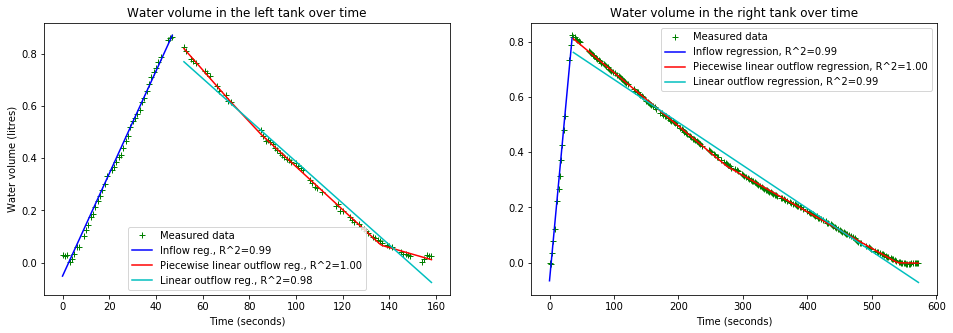

In [30]:
from sklearn.metrics import r2_score

# The regressions are applied on the data points.
inflow_pred_left = inflow_left.predict(inflow_x_left)
inflow_pred_right = inflow_right.predict(inflow_x_right)

outflow_pred_left = outflow_left.predict(outflow_x_left[:, 0])
outflow_pred_right = outflow_right.predict(outflow_x_right[:, 0])

lin_out_pred_left = lin_outflow_left.predict(outflow_x_left)
lin_out_pred_right = lin_outflow_right.predict(outflow_x_right)

# The R^2 scores are computed.
r2_inflow_left = r2_score(inflow_y_left, inflow_pred_left)
r2_inflow_right = r2_score(inflow_y_right, inflow_pred_right)

r2_outflow_left = r2_score(outflow_y_left, outflow_pred_left)
r2_outflow_right = r2_score(outflow_y_right, outflow_pred_right)

r2_lin_out_left = r2_score(outflow_y_left, lin_out_pred_left)
r2_lin_out_right = r2_score(outflow_y_right, lin_out_pred_right)

# The regressions and their scores are plotted.
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(xflow_left, yflow_left, '+g')
ax1.plot(inflow_x_left, inflow_pred_left, '-b')
ax1.plot(outflow_x_left, outflow_pred_left, '-r')
ax1.plot(outflow_x_left, lin_out_pred_left, '-c')
plt.xlabel('Time (seconds)')
plt.ylabel('Water volume (litres)')
ax1.set_title("Water volume in the left tank over time")
ax1.legend(["Measured data",
            "Inflow reg., R^2={:.2f}".format(r2_inflow_left),
            "Piecewise linear outflow reg., R^2={:.2f}"
            .format(r2_outflow_left),
            "Linear outflow reg., R^2={:.2f}"
            .format(r2_lin_out_left)])

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(xflow_right, yflow_right, '+g')
ax2.plot(inflow_x_right, inflow_pred_right, '-b')
ax2.plot(outflow_x_right, outflow_pred_right, '-r')
ax2.plot(outflow_x_right, lin_out_pred_right, '-c')
plt.xlabel('Time (seconds)')
ax2.set_title("Water volume in the right tank over time")
ax2.legend(["Measured data",
            "Inflow regression, R^2={:.2f}".format(r2_inflow_right),
            "Piecewise linear outflow regression, R^2={:.2f}"
            .format(r2_outflow_right),
            "Linear outflow regression, R^2={:.2f}"
            .format(r2_lin_out_right)])

### Estimation of the flow rates
The volumetric flow rate is defined as the first derivative of the function describing the volume passing through some surface over time. Hence, once the volume/time functions of the two tanks have been learned as shown above, their incoming and outgoing flow rates can be determined by taking the slopes of their volume/time functions.

In [38]:
print("Estimated inflow for the left tank: {:.6f} l/s\n".format(inflow_left.coef_[0][0]))
print("Estimated inflow for the right tank: {:.6f} l/s\n".format(inflow_right.coef_[0][0]))

print("Estimated outflow for the left tank: ")
for i in range(3):
    vi = outflow_left.predict([intervals_left[i]])
    vi1 = outflow_left.predict([intervals_left[i+1]])
    print("\t{:.6f} l/s from {:.3f}L to {:.3f}L, "
          .format(outflow_left.slopes[i], vi[0], vi1[0]))
    
print("\nEstimated outflow for the right tank: ")
for i in range(3):
    vi = outflow_right.predict([intervals_right[i]])
    vi1 = outflow_right.predict([intervals_right[i+1]])
    print("\t{:.6f} l/s from {:.3f}L to {:.3f}L, "
          .format(outflow_right.slopes[i], vi[0], vi1[0]))

Estimated inflow for the left tank: 0.019645 l/s

Estimated inflow for the right tank: 0.025127 l/s

Estimated outflow for the left tank: 
	-0.010198 l/s from 0.821L to 0.525L, 
	-0.008264 l/s from 0.525L to 0.066L, 
	-0.002571 l/s from 0.066L to 0.011L, 

Estimated outflow for the right tank: 
	-0.001941 l/s from 0.811L to 0.349L, 
	-0.001323 l/s from 0.349L to -0.001L, 
	-0.000044 l/s from -0.001L to -0.002L, 
